参考: [MFCC（メル周波数ケプストラム係数）入門 - Qiita](https://qiita.com/tmtakashi_dist/items/eecb705ea48260db0b62)

In [1]:
using WAV
using Plots
using DSP
using FFTW
using LinearAlgebra

In [2]:
# 音声ファイルの読み込み
master, fs = wavread("./wav.wav")

([-0.0009155552842799158; -0.000946073793755913; … ; 0.0006714072084719382; 0.000946073793755913], 44100.0f0, 0x0010, WAVChunk[WAVChunk(Symbol("fmt "), UInt8[0x10, 0x00, 0x00, 0x00, 0x01, 0x00, 0x01, 0x00, 0x44, 0xac, 0x00, 0x00, 0x88, 0x58, 0x01, 0x00, 0x02, 0x00, 0x10, 0x00])])

In [3]:
t = range(0, length(master)/fs; step=1/fs)

0.0f0:2.2675737f-5:2.3899999f0

In [4]:
# 音声波形の中心部分を切り出す
center = Int(floor(length(master)/2))
cuttime = 0.04
x = master[Int(center - cuttime / 2 * fs):Int(center + cuttime / 2 * fs)];
time = t[Int(center - cuttime / 2 * fs):Int(center + cuttime / 2 * fs)];

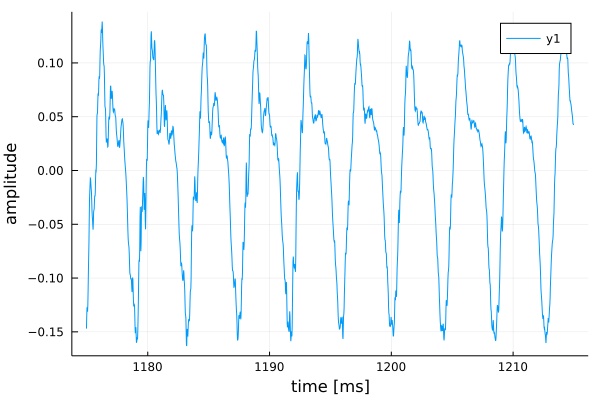

In [5]:
plot(time * 1000, x)
xlabel!("time [ms]")
ylabel!("amplitude")

In [6]:
# ハミング窓をかける
hamming_fn = hamming(length(x));
x = x .* hamming_fn;

In [8]:
# 振幅スペクトルを求める
N = length(x)
spec = abs.(fft(x))[1:Int(floor(N/2))];
fscale = FFTW.fftfreq(N, fs)[1:Int(floor(N/2))];

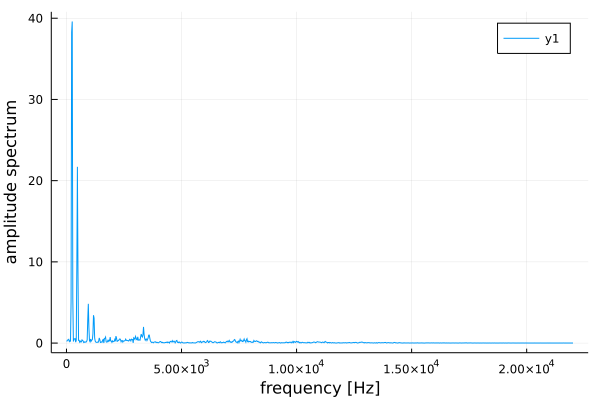

In [9]:
plot(fscale, spec)
xlabel!("frequency [Hz]")
ylabel!("amplitude spectrum")

## メルフィルタバンクをかける

In [10]:
function hz2mel(f)
    return 2595 * log(f / 700 + 1.0)
end

hz2mel (generic function with 1 method)

In [11]:
function mel2hs(m)
    return 700 .* (exp.(m ./ 2595) .- 1.0)
end

mel2hs (generic function with 1 method)

In [12]:
# メルフィルタバンクの作成
function melFilterBank(fs, N, numChannels)
    # ナイキスト周波数(Hx)
    fmax = fs / 2
    # ナイキスト周波数(mel)
    melmax = hz2mel(fmax)
    # 周波数インデックスの最大値
    nmax = floor(N/2)
    # 周波数解像度
    df = fs / N
    # メル尺度におけるフィルタの中心周波数
    dmel = melmax / (21)
    melcenters = range(1, 21; step=1) .* dmel
    # 各フィルタの中心周波数をHzに変換
    fcenters = mel2hs(melcenters);
    # 各フィルタの中心周波数を周波数インデックスに変換
    indexcenter = round.(fcenters ./ df);
    indexstart = append!([1], indexcenter[1:20])
    indexstop = append!(indexcenter[2:end], [nmax])

    filterbank = zeros(21, Int(nmax));
    for c in range(1, 21; step=1)
        # 三角フィルタの左の直線の傾きから点を求める
        increment = 1.0 / (indexcenter[c] - indexstart[c])
        for i in range(Int(indexstart[c]), Int(indexcenter[c]); step=1)
            filterbank[c, i] = (i - indexstart[c]) * increment
        end
        # 三角フィルタの右の直線の傾きから点を求める
        decrement = 1.0 / (indexstop[c] - indexcenter[c])
        for i in range(Int(indexcenter[c]), Int(indexstop[c]); step=1)
            filterbank[c, i] = 1.0 - ((i - indexcenter[c]) * decrement)
            if isnan(filterbank[c, i])
                filterbank[c, i] = 1.0
            end
        end
    end
    
    return filterbank, fcenters
end

melFilterBank (generic function with 1 method)

In [13]:
numChannels = 20
(filterbank, fcenters) = melFilterBank(fs, N, numChannels)

([0.0 0.25 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.007194244604316502 0.0; 0.0 0.0 … 0.9928057553956835 1.0], [126.21387834999085, 275.1848182544762, 451.016043997231, 658.5506139343084, 903.504816676323, 1192.6256193414797, 1533.876504600968, 1936.6568151732665, 2412.060647346056, 2973.182424434526  …  4417.1881928396, 5339.845575789694, 6428.863196868908, 7714.23672873082, 9231.370229999473, 11022.051307225005, 13135.602103942787, 15630.237819436952, 18574.670175963856, 22049.99999999999])

In [15]:
df = fs / N

24.985836f0

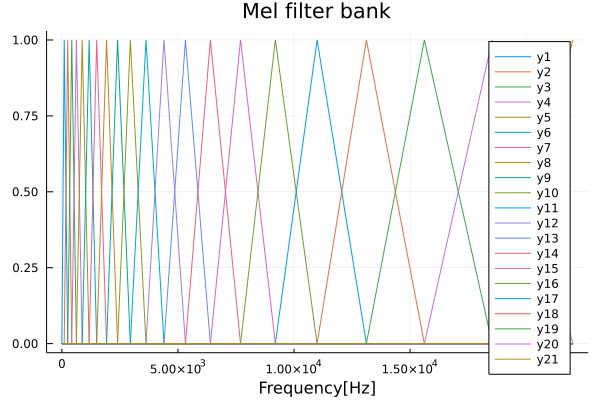

In [17]:

plot(range(0, N/2-1; step=1) * df, filterbank[1, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[2, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[3, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[4, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[5, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[6, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[7, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[8, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[9, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[10, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[11, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[12, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[13, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[14, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[15, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[16, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[17, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[18, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[19, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[20, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[21, :])
title!("Mel filter bank")
xlabel!("Frequency[Hz]")

In [18]:
# 振幅スペクトルにメルフィルタバンクを適用
mspec = filterbank * spec;

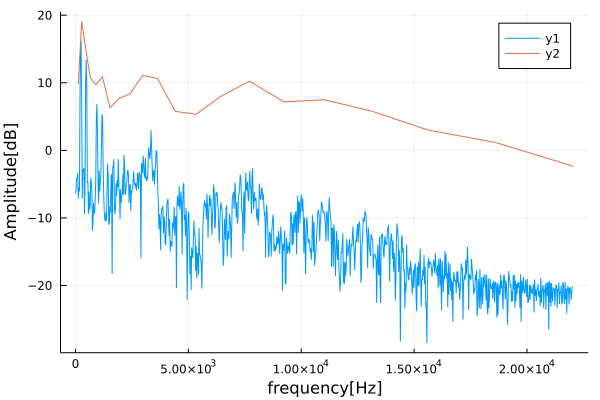

In [19]:
plot(fscale, 10 * log10.(spec))
plot!(fcenters, 10 * log10.(mspec))
xlabel!("frequency[Hz]")
ylabel!("Amplitude[dB]")

## 離散コサイン変換を行う

In [20]:
ceps = dct(10 * log10.(mspec))
mfcc = ceps[1:12]

12-element Vector{Float64}:
 37.30816355636851
 15.038431649814608
 -1.3045960638152996
  8.227474323172503
 -2.0139342170632633
  3.9523287958333677
 -3.8177072960036686
 -3.5989514878012203
 -0.8141040820702073
  1.0700921440941848
 -4.847713658485811
 -4.5508572470485005